In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stopwords_eng.txt', 'valid_lyrics_rem_200.csv', 'train_lyrics_rem_1000.csv', 'valid_lyrics_200.csv', 'train_lyrics_1000.csv', 'label_encoder.p', 'train_1000.csv', 'label_encoder.p.txt', 'stopwords.p']


libraries for dataset preparation, feature engineering, model training 

In [2]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


**1. Dataset preparation**
For the purpose of this project, I am the using dataset of music lyrics which can be obtained from sebastain rashka github. The dataset consists of 100k text lyrics and their labels as happy and sad, we will use whole data. To prepare the dataset, load the downloaded data into a pandas dataframe containing two columns – text and label. 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import seaborn as sns
trainDF = pd.read_csv('../input/train_lyrics_1000.csv', usecols=range(7))
validDF =pd.read_csv('../input/valid_lyrics_200.csv')
print("Validation data with lyrics and labels",validDF.head())
#print("Trainning Data with lyrics,title,singer,genre and mood label")
# trainDF['lyrics'] = lyrics
# trainDF['mood'] = mood
trainDF.head()

Validation data with lyrics and labels                     file  ...     mood
0  TRAFAIB128F426E636.h5  ...    happy
1  TRAFAJC128E078888B.h5  ...      sad
2  TRAFBBP128F92F6CC9.h5  ...    happy
3  TRAFBVU128F426B3F6.h5  ...      sad
4  TRAFEEO12903CFEC87.h5  ...      sad

[5 rows x 6 columns]


,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [5]:
train_x =trainDF['lyrics']
train_y =trainDF['mood']
valid_x =validDF['lyrics']
valid_y =validDF['mood']

In [8]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

**2. Feature Engineering**

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

2.1 Count Vectors as features
2.2 TF-IDF Vectors as features

Word level
N-Gram level
Character level
2.3 Word Embeddings as features
2.4 Text / NLP based features
2.5 Topic Models as features

Lets look at the implementation of these ideas in detail.

In [9]:
import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()

def porter_tokenizer(text, stemmer=porter_stemmer):
    """
    A Porter-Stemmer-Tokenizer hybrid to splits sentences into words (tokens) 
    and applies the porter stemming algorithm to each of the obtained token. 
    Tokens that are only consisting of punctuation characters are removed as well.
    Only tokens that consist of more than one letter are being kept.
    
    Parameters
    ----------
        
    text : `str`. 
      A sentence that is to split into words.
        
    Returns
    ----------
    
    no_punct : `str`. 
      A list of tokens after stemming and removing Sentence punctuation patterns.
    
    """
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct


In [10]:
# Commented out to prevent overwriting files:
#
# stp = nltk.corpus.stopwords.words('english')
# with open('./stopwords_eng.txt', 'w') as outfile:
#    outfile.write('\n'.join(stp))
    
    
with open('../input/stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


**2.1 Count Vectors as features**
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [11]:
# create a count vectorizer object 
#analyzer='word',
                      
                      
                       
                     
count_vect = CountVectorizer(analyzer='word',preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),stop_words=stop_words,
            tokenizer=porter_tokenizer,ngram_range=(1,1))
count_vect.fit(trainDF['lyrics'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


**2.2 TF-IDF Vectors as features**
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus

In [12]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()), max_features=5000)
tfidf_vect.fit(trainDF['lyrics'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()), ngram_range=(2,2), max_features=5000)
tfidf_vect_ngram.fit(trainDF['lyrics'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()), ngram_range=(1,1), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['lyrics'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

**3. Model Building**
The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:

Naive Bayes Classifier
Linear Classifier
Support Vector Machine
Bagging Models
Boosting Models
Shallow Neural Networks

In [13]:
#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve,f1_score
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#load package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from math import sqrt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Lets implement these models and understand their details. The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.

In [14]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(),
    
    ]

In [15]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf.toarray(), train_y).predict(xvalid_tfidf.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(xtrain_tfidf.toarray(), train_y), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(xvalid_tfidf.toarray(), valid_y), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    MLA_compare.loc[row_index, 'MLA F1 Score'] = f1_score(valid_y, predicted)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC,MLA F1 Score
11,BernoulliNB,0.926,0.725,0.696078,0.747368,0.726065,0.720812
15,NuSVC,0.834,0.705,0.663636,0.768421,0.708020,0.712195
6,LogisticRegressionCV,0.997,0.675,0.629310,0.768421,0.679449,0.691943
8,RidgeClassifierCV,0.979,0.675,0.625000,0.789474,0.680451,0.697674
16,LinearSVC,0.993,0.670,0.623932,0.768421,0.674687,0.688679
7,PassiveAggressiveClassifier,0.993,0.665,0.620690,0.757895,0.669424,0.682464
9,SGDClassifier,0.858,0.655,0.795455,0.368421,0.641353,0.503597
10,Perceptron,0.984,0.655,0.612069,0.747368,0.659398,0.672986
3,GradientBoostingClassifier,0.959,0.650,0.603306,0.768421,0.655639,0.675926
5,GaussianProcessClassifier,0.884,0.625,0.564103,0.926316,0.639348,0.701195


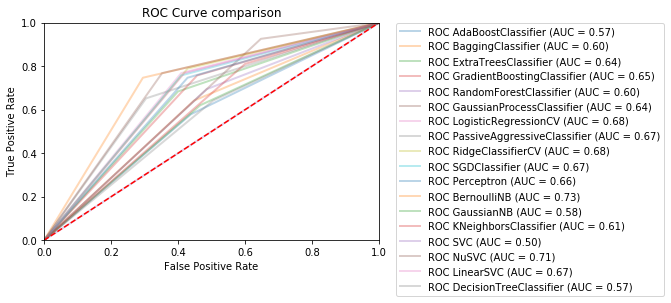

In [16]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf.toarray(), train_y).predict(xvalid_tfidf.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

In [17]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_count.toarray(), train_y).predict(xvalid_count.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(xtrain_count.toarray(), train_y), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(xvalid_count.toarray(), valid_y), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    MLA_compare.loc[row_index, 'MLA F1 Score'] = f1_score(valid_y, predicted)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC,MLA F1 Score
11,BernoulliNB,0.937,0.690,0.651376,0.747368,0.692732,0.696078
15,NuSVC,0.946,0.685,0.635593,0.789474,0.689975,0.704225
9,SGDClassifier,0.900,0.680,0.691358,0.589474,0.675689,0.636364
6,LogisticRegressionCV,0.998,0.665,0.625000,0.736842,0.668421,0.676329
10,Perceptron,0.935,0.655,0.614035,0.736842,0.658897,0.669856
4,RandomForestClassifier,0.988,0.650,0.621359,0.673684,0.651128,0.646465
16,LinearSVC,0.998,0.645,0.605263,0.726316,0.648872,0.660287
7,PassiveAggressiveClassifier,0.970,0.645,0.607143,0.715789,0.648371,0.657005
0,AdaBoostClassifier,0.791,0.635,0.596491,0.715789,0.638847,0.650718
3,GradientBoostingClassifier,0.921,0.630,0.585366,0.757895,0.636090,0.660550


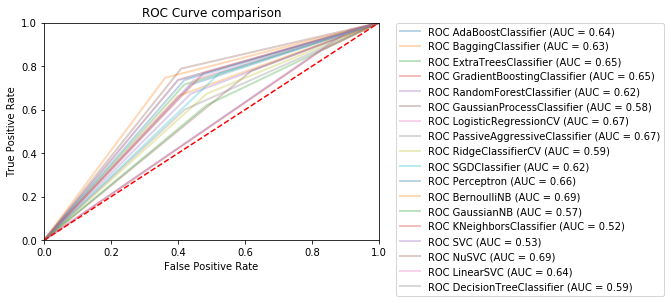

In [18]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_count.toarray(), train_y).predict(xvalid_count.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

In [19]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf_ngram.toarray(), train_y).predict(xvalid_tfidf_ngram.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(xtrain_tfidf_ngram.toarray(), train_y), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(xvalid_tfidf_ngram.toarray(), valid_y), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    MLA_compare.loc[row_index, 'MLA F1 Score'] = f1_score(valid_y, predicted)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC,MLA F1 Score
11,BernoulliNB,0.951,0.645,0.585714,0.863158,0.655388,0.697872
7,PassiveAggressiveClassifier,0.996,0.630,0.610526,0.610526,0.629073,0.610526
10,Perceptron,0.990,0.625,0.589286,0.694737,0.628321,0.637681
15,NuSVC,0.801,0.615,0.584906,0.652632,0.616792,0.616915
8,RidgeClassifierCV,0.997,0.615,0.566176,0.810526,0.624311,0.666667
9,SGDClassifier,0.875,0.610,0.757576,0.263158,0.593484,0.390625
6,LogisticRegressionCV,0.997,0.610,0.566929,0.757895,0.617043,0.648649
1,BaggingClassifier,0.985,0.610,0.589474,0.589474,0.609023,0.589474
16,LinearSVC,0.997,0.605,0.563492,0.747368,0.611779,0.642534
12,GaussianNB,0.994,0.605,0.566667,0.715789,0.610276,0.632558


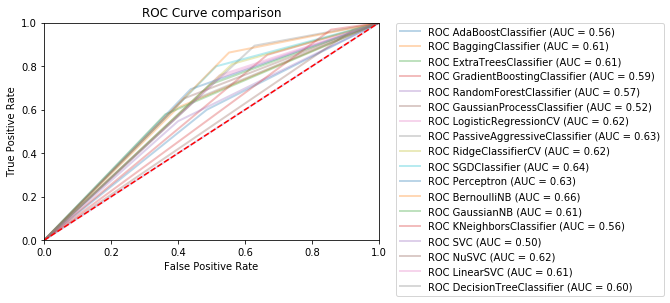

In [20]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf_ngram.toarray(), train_y).predict(xvalid_tfidf_ngram.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

In [21]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf_ngram_chars.toarray(), train_y).predict(xvalid_tfidf_ngram_chars.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(xtrain_tfidf_ngram_chars.toarray(), train_y), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(xvalid_tfidf_ngram_chars.toarray(), valid_y), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(valid_y, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)
    MLA_compare.loc[row_index, 'MLA F1 Score'] = f1_score(valid_y, predicted)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC,MLA F1 Score
12,GaussianNB,0.578,0.595,0.597222,0.452632,0.588221,0.514970
8,RidgeClassifierCV,0.611,0.590,0.546763,0.800000,0.600000,0.649573
0,AdaBoostClassifier,0.740,0.585,0.550000,0.694737,0.590226,0.613953
16,LinearSVC,0.615,0.585,0.544118,0.778947,0.594236,0.640693
4,RandomForestClassifier,0.989,0.580,0.557895,0.557895,0.578947,0.557895
1,BaggingClassifier,0.985,0.575,0.552083,0.557895,0.574185,0.554974
17,DecisionTreeClassifier,0.998,0.575,0.550000,0.578947,0.575188,0.564103
6,LogisticRegressionCV,0.627,0.575,0.539062,0.726316,0.582206,0.618834
3,GradientBoostingClassifier,0.913,0.575,0.538462,0.736842,0.582707,0.622222
10,Perceptron,0.575,0.560,0.544304,0.452632,0.554887,0.494253


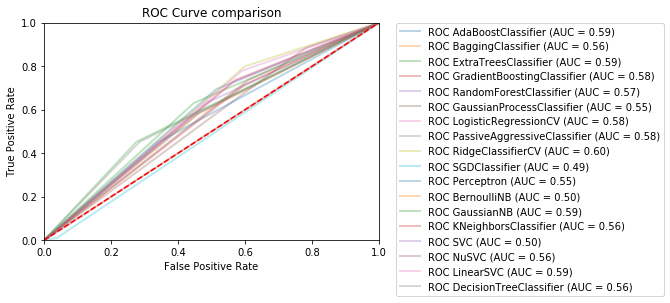

In [22]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(xtrain_tfidf_ngram_chars.toarray(), train_y).predict(xvalid_tfidf_ngram_chars.toarray())
    fp, tp, th = roc_curve(valid_y, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

In [23]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

Implementing a naive bayes model using sklearn implementation with different features

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature 

In [ ]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
accuracy1 = train_model(naive_bayes.BernoulliNB(), xtrain_count, train_y, xvalid_count)
print ("MultinomialNB, Count Vectors: ", accuracy)
print ("BernoulliNB, Count Vectors: ", accuracy1)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy1 = train_model(naive_bayes.BernoulliNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("MultinomialNB, WordLevel TF-IDF: ", accuracy)
print ("BernoulliNB, WordLevel TF-IDF: ", accuracy1)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy1 = train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("MulitnomialNB, N-Gram Vectors: ", accuracy)
print ("BernoulliNB, N-Gram Vectors: ", accuracy1)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
accuracy1 = train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("MultinomialNB, CharLevel Vectors: ", accuracy)
print ("BernoulliNB, CharLevel Vectors: ", accuracy1)

**3.2 Linear Classifier**
Implementing a Linear Classifier (Logistic Regression)

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. One can read more about logistic regression here

In [ ]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

3.3 Implementing a SVM Model
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes

In [ ]:
accuracy = train_model(svm.SVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(svm.SVC(), xtrain_count, train_y, xvalid_count)
print ("SVM, Count Vectors: ", accuracy)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

3.4 Bagging Model
Implementing a Random Forest Model

Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family.

In [ ]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

3.5 Boosting Model
Implementing Xtereme Gradient Boosting Model

Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing)

In [ ]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

**3.6 Shallow Neural Networks**
A neural network is a mathematical model that is designed to behave similar to biological neurons and nervous system. These models are used to recognize complex patterns and relationships that exists within a labelled data. A shallow neural network contains mainly three types of layers – input layer, hidden layer, and output layer. 

In [ ]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
print ("NN, Ngram Level TF IDF Vectors",  accuracy)
